# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')
model.type = 'deep'

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, 2)
Categorical columns: 1
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.0:1.2:1.1:1.1:1.1:1.0:1.0:1.1:1.0:1.0
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.2:1.4:1.2:1.1:1.3:1.1:1.0:1.2:1.3:1.3
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       686 |     584 |    102 |
|  1 |       780 |     664 |    116 |
|  2 |       724 |     623 |    101 |
|  3 |       722 |     631 |     91 |
|  4 |       700 |     595 |    105 |
|  5 |       650 |     560 |     90 |
|  6 |       658 |     575 |     83 |
|  7 |       715 |     614 |    101 |
|  8 |       676 |     572 |    104 |
|  9 |       689 |     5

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       7
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       1
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       4
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6

Every row in the column contains the data of one image, with shape: (28, 28, 1)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 32}
Evaluation --> f1_weighted: 0.9358  Best f1_weighted: 0.9358
Time iteration: 15.137s   Total time: 15.142s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9433  Best f1_weighted: 0.9433
Time iteration: 8.192s   Total time: 23.334s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9534  Best f1_weighted: 0.9534
Time iteration: 13.199s   Total time: 36.533s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 32}
Evaluation --> f1_weighted: 0.9467  Best f1_weighted: 0.9534
Time iteration: 10.146s   Total time: 46.679s
Initial point 5 ---------------------------------
Parameters --> {'

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[8.76596175e-07, 1.38764403e-06, 1.52839746e-07, ...,
        1.60703712e-04, 2.06854588e-06, 1.32981916e-06],
       [9.99999523e-01, 2.22466728e-12, 5.39773781e-10, ...,
        2.64158712e-11, 1.49185428e-08, 9.51618304e-08],
       [1.07633139e-11, 5.70476652e-11, 2.90564600e-07, ...,
        1.21735468e-06, 1.23234195e-05, 2.50268067e-06],
       ...,
       [1.65581515e-09, 5.82741841e-11, 2.68326705e-14, ...,
        2.05556631e-11, 1.10646642e-05, 2.90689983e-09],
       [6.31913792e-07, 2.37590709e-14, 3.49165502e-10, ...,
        1.30634904e-11, 7.05326205e-12, 6.08686296e-11],
       [1.42169056e-05, 2.93578211e-07, 6.90621755e-06, ...,
        4.18749050e-06, 9.99746978e-01, 1.23877708e-05]], dtype=float32)

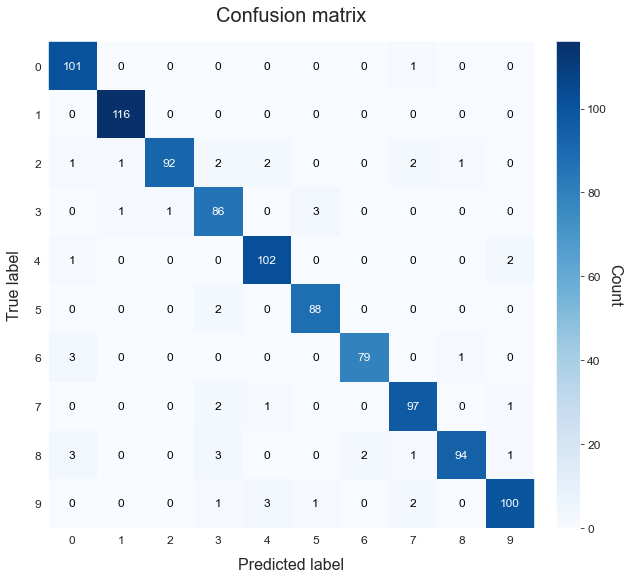

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()